In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import lumicks.pylake as lk

%matplotlib inline

# Force Calibration

[Download this page as a Jupyter notebook](https://lumicks-pylake.readthedocs.io/en/stable/_downloads/79cac5929d2d17798993697d99faef03/force_calibration.ipynb)

Force calibration refers to computing the calibration factors needed to convert a raw voltage recorded by a position sensitive detector to actual force and displacement. The values we wish to calculate are:

* Trap stiffness $\kappa$, which reflects how strongly a bead is held by a trap.
  
* Force response $R_d$, the proportionality constant between voltage and force.
  
* Distance response $R_f$, the proportionality constant between voltage and distance.
  
This tutorial will focus on performing force calibration with Pylake. Note that force calibration in Bluelake is actually performed by Pylake. Therefore, the results obtained with Bluelake can be reproduced exactly when using the same data and parameters.

To calibrate the optical traps we fit a power spectrum of the voltage measured by a position sensitive diode (PSD) to a theoretical model. The measured voltage (and thus the shape of the power spectrum) is mainly determined by

* The Brownian motion of the bead within the trap.
  
* The instantaneous response of the PSD to the incident light.
  
The contribution to the power spectrum by the bead in the optical trap is characterized by a diffusion constant and a corner frequency. The second contribution refers to a filtering effect where the PSD becomes less sensitive to changes in signal at high frequencies. This filtering effect is characterized by a constant that reflects the fraction of light that is transmitted instantaneously and a corner frequency (this is referred to as the diode frequency to be able to differentiate).

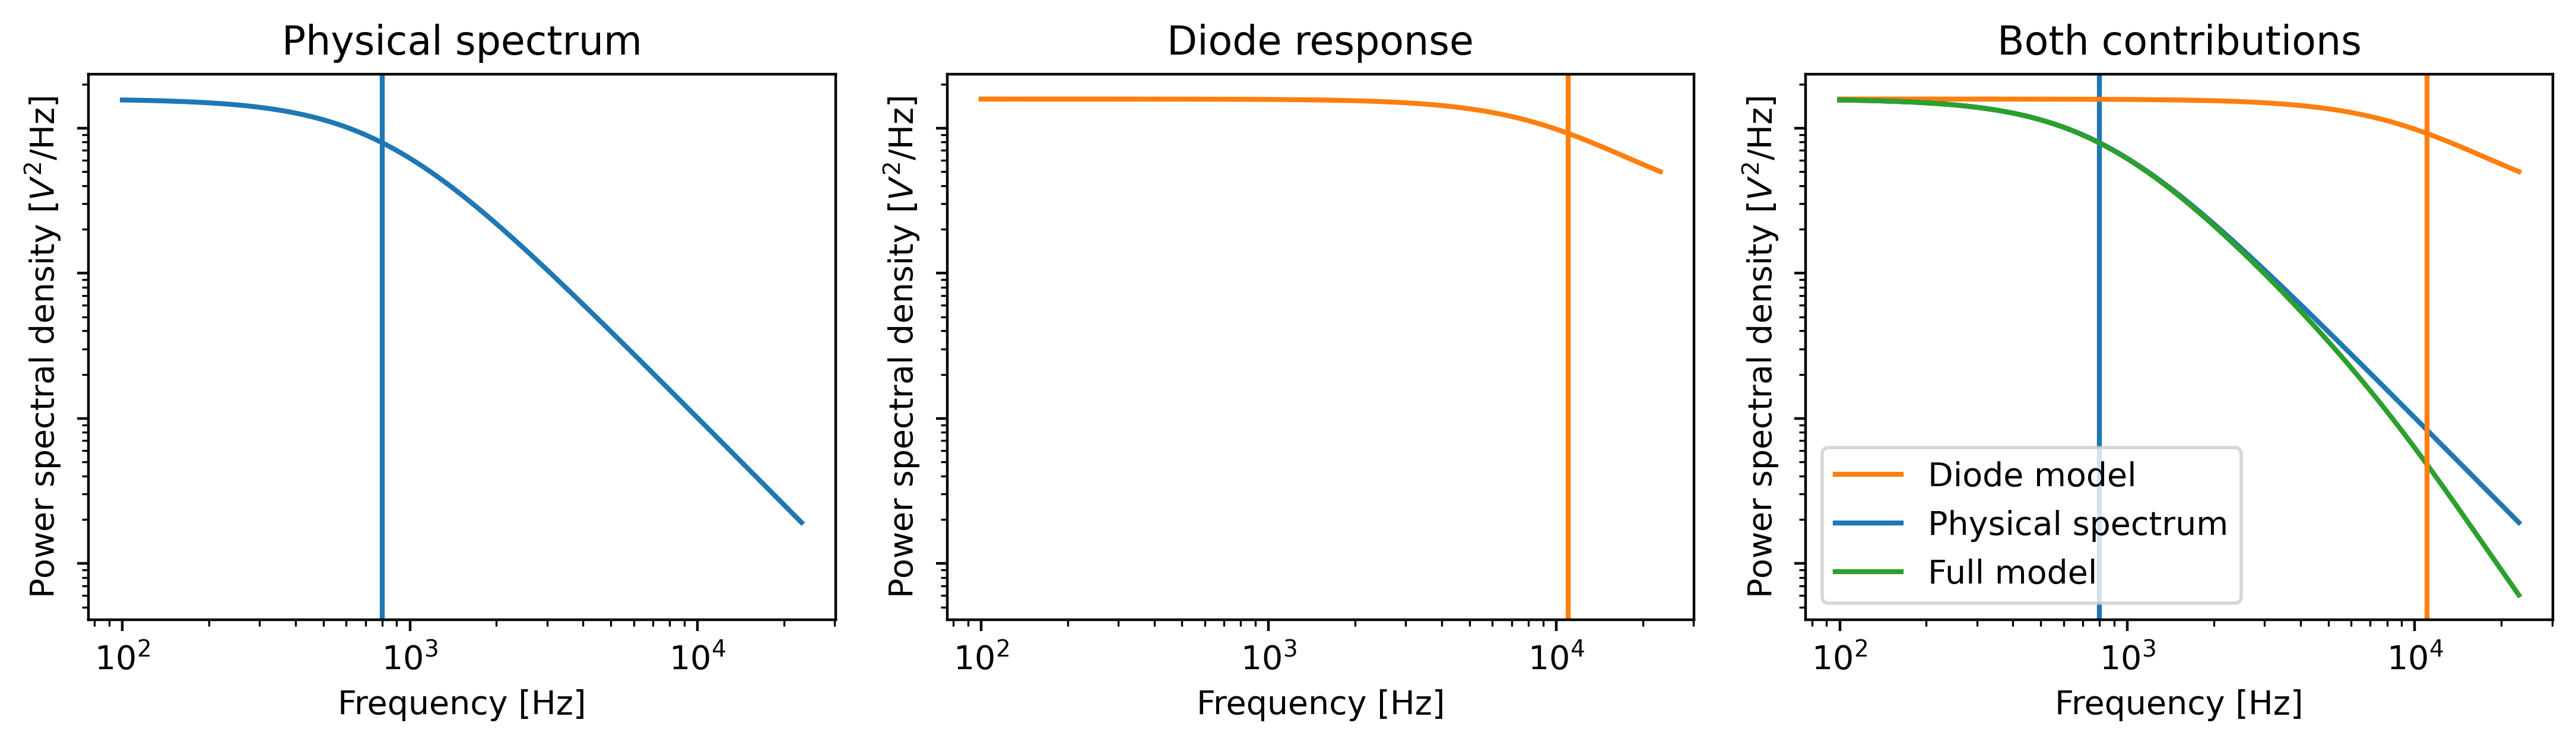

<div class="alert alert-block alert-danger"><b>Warning: </b>For high corner frequencies, the parameter estimation procedure can become unreliable. A warning sign for this is when the corner frequency `f_c` approaches or goes beyond the diode frequency `f_diode`. For more information see the section on <a href="#high-corner-frequencies">High corner frequencies</a>.</div>

The various theoretical models that can be used to fit these data are described in the [theory section on force calibration](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../theory/force_calibration/force_calibration.html), while their use is described below.

We can download the data needed for this tutorial directly from Zenodo using Pylake. Since we don’t want it in our working folder, we’ll put it in a folder called `"test_data"`:

In [ ]:
filenames = lk.download_from_doi("10.5281/zenodo.7729823", "test_data")

## Undoing the previous calibration

Our starting point will be data acquired with Bluelake, which is already calibrated. Therefore, the first step is to undo the calibration applied by Bluelake to get the raw voltage signals. Let’s load the dataset:

In [ ]:
f = lk.File("test_data/passive_calibration.h5")

The force timeline in this file contains a single calibration measurement. We can see calibrations relevant to this file by inspecting the `calibration` attribute for the entire force [`Slice`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.channel.Slice.html#lumicks.pylake.channel.Slice). This is a list of dictionaries containing all of the relevant calibration parameters:

In [ ]:
print(len(f.force1x.calibration))
print(f.force1x.calibration[1])

The first calibration item in the dictionary always refers to the calibration that was active at the start of the slice (usually from a calibration that occurred before the start of the slice). The second calibration refers to the calibration measurement performed in this slice. This is illustrated in the figure below:

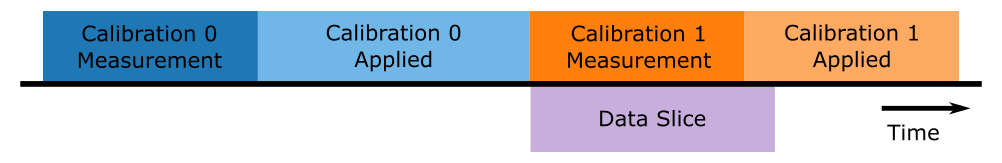

Our goal here is to reproduce the calibration factors calculated from the calibration measurement corresponding to `calibrations[1]`. First we grab the chunk of data that was used for that calibration in Bluelake:

In [ ]:
start = f.force1x.calibration[1]["Start time (ns)"]
stop = f.force1x.calibration[1]["Stop time (ns)"]
force_slice = f.force1x[start:stop]

Now we can see that this new [`Slice`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.channel.Slice.html#lumicks.pylake.channel.Slice) only contains a single calibration:

In [ ]:
print(len(force_slice.calibration))

Next we’ll decalibrate the force data back to the original voltage measured by the PSD. Let’s write a short function for this so we can reuse it elsewhere:

In [ ]:
def decalibrate(force_slice):
    offset = force_slice.calibration[0]["Offset (pN)"]
    response = force_slice.calibration[0]["Rf (pN/V)"]
    return (force_slice - offset) / response

volts = decalibrate(force_slice)

## Performing the calibration

For convenience, Pylake offers [`calibrate_force()`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.calibrate_force.html#lumicks.pylake.calibrate_force) which performs an entire calibration procedure in a single function call:

In [ ]:
calibration = lk.calibrate_force(
    volts.data,
    force_slice.calibration[0]["Bead diameter (um)"],  # Use the value from the last calibration
    temperature=25,
    sample_rate=volts.sample_rate
)

This function allows us to quickly try various calibration settings without having to set up all the intermediate models and spectra explicitly. Note that most parameters have to be provided as keyworded arguments to prevent errors. This method returns a [`CalibrationResults`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.force_calibration.power_spectrum_calibration.CalibrationResults.html#lumicks.pylake.force_calibration.power_spectrum_calibration.CalibrationResults), which can be plotted using [`plot()`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.force_calibration.power_spectrum_calibration.CalibrationResults.html#lumicks.pylake.force_calibration.power_spectrum_calibration.CalibrationResults.plot).

The rest of this tutorial illustrates the various steps involved when performing such a calibration.

## Obtaining the power spectrum

To use the more manual lower-level API, we first need the power spectrum to fit. To compute a power spectrum from our data we can invoke [`calculate_power_spectrum()`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.calculate_power_spectrum.html#lumicks.pylake.calculate_power_spectrum):

In [ ]:
power_spectrum = lk.calculate_power_spectrum(volts.data, sample_rate=volts.sample_rate)

This function returns a [`PowerSpectrum`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.force_calibration.power_spectrum.PowerSpectrum.html#lumicks.pylake.force_calibration.power_spectrum.PowerSpectrum) which we can plot:

In [ ]:
plt.figure()
power_spectrum.plot()
plt.show()

The power spectrum is smoothed by downsampling adjacent power spectral values (known as blocking). Downsampling the spectrum is required to fulfill some of the assumptions in the fitting procedure, but it comes at the cost of spectral resolution. One must be careful that the shape of the power spectrum is still sufficiently preserved. If the corner frequency is very low then downsampling too much can lead to biases in the calibration parameters. In such cases, it is better to either measure a longer interval to increase the spectral resolution or reduce the number of points (`num_points_per_block`) used for blocking.

The range over which to compute the spectrum can be controlled using the `fit_range` argument. One can also exclude specific frequency ranges from the spectrum (`excluded_ranges`) which can be useful if there are noise peaks in the spectrum. Let’s see which ranges were excluded in our Bluelake calibration:

In [ ]:
force_slice.calibration[0]

Here, they are listed as `Exclusion range 0 (min.) (Hz)`, `Exclusion range 0 (max.) (Hz)` etc. To reproduce the result obtained with Bluelake, these should be excluded from the power spectrum:

In [ ]:
power_spectrum = lk.calculate_power_spectrum(
    volts.data,
    sample_rate=volts.sample_rate,
    fit_range=(1e2, 23e3),
    num_points_per_block=2000,
    excluded_ranges=([19348, 19668], [24308, 24548])
)

plt.figure()
power_spectrum.plot(marker=".")
plt.show()

Note that exclusion ranges are excluded prior to downsampling. Considering that a noise peak may be very narrow, it is beneficial to lower the number of points per block temporarily to find the exact exclusion range. After determination of this exclusion range, the number of points per block can be increased again. However, also see [Robust fitting](#id4) for an automated peak identification routine.

## Passive calibration

In literature, passive calibration is often referred to as thermal calibration. It involves fitting a physical model to the power spectrum obtained in the previous step. This physical model relies on a number of parameters that have to be specified in order to get the correct calibration factors.

The most important of these is the bead diameter (in microns). Let’s use the bead diameter found in the calibration performed in Bluelake.

You can optionally also provide a viscosity (in Pa/s) and temperature (in degrees Celsius). To find the viscosity of water at a particular temperature, Pylake uses [`viscosity_of_water()`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.viscosity_of_water.html#lumicks.pylake.viscosity_of_water) which implements the model presented in [[HPL+09](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../zrefs.html#id27)]. When omitted, this function will automatically be used to look up the viscosity of water for that particular temperature

<div class="alert alert-block alert-info"><b>Note: </b>Note that for experiments that use a different medium than water, the viscosity at the experimental temperature should explicitly be provided.</div>

The next step is setting up the calibration model:

In [ ]:
bead_diameter = f.force1x.calibration[1]["Bead diameter (um)"]
force_model = lk.PassiveCalibrationModel(bead_diameter, temperature=25)

To fit this model to the data use [`fit_power_spectrum()`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.fit_power_spectrum.html#lumicks.pylake.fit_power_spectrum):

In [ ]:
calibration = lk.fit_power_spectrum(power_spectrum, force_model)
calibration

This will produce a table with your fitted calibration parameters. These parameters can be accessed as follows:

In [ ]:
print(calibration["kappa"].value)
print(f.force1x.calibration[1]["kappa (pN/nm)"])

<div class="alert alert-block alert-info"><b>Note: </b>Note that by default, a bias correction is applied to the fitted results [<a href="https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../zrefs.html#id33">NF10</a>]. This bias correction is applied to the diffusion constant and amounts to a correction of $\frac{N}{N+1}$, where $N$ refers to the number of points used for a particular spectral data point. It can optionally be disabled by passing `bias_correction=False` to <a href="https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.fit_power_spectrum.html#lumicks.pylake.fit_power_spectrum">`fit_power_spectrum()`</a> or <a href="https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.calibrate_force.html#lumicks.pylake.calibrate_force">`calibrate_force()`</a>.</div>

We can plot the calibration by calling:

In [ ]:
plt.figure()
calibration.plot()
plt.show()

## Hydrodynamically correct model

While the simple theory can suffice for small beads, it is usually a good idea to use the more realistic hydrodynamically correct model. This model takes into account hydrodynamic and inertial effects (which scale with the size of the bead) leading to more accurate estimates. As such, it requires a few extra parameters: the density of the sample and bead:

In [ ]:
force_model = lk.PassiveCalibrationModel(
    bead_diameter,
    hydrodynamically_correct=True,
    rho_sample=999,
    rho_bead=1060.0
)

Note that when `rho_sample` and `rho_bead` are omitted, values for water and polystyrene are used for the sample and bead density respectively.

## Calibration near the surface

So far, we have only considered experiments performed deep in bulk. In reality, proximity of the flowcell surface to the bead leads to an increase in the drag force on the bead. Such surface effects can be taken into account by specifying a distance to the surface (in microns):

In [ ]:
force_model = lk.PassiveCalibrationModel(
    bead_diameter,
    hydrodynamically_correct=True,
    rho_sample=999,
    rho_bead=1060.0,
    distance_to_surface=5
)

As we approach the surface, the drag effect becomes stronger. The hydrodynamically correct model is only valid up to a certain distance to the surface. Moving closer, the frequency dependent effects become smaller than the overall drag effect and better models to approximate the local drag exist. We can use this model by setting `hydrodynamically_correct` to `False`, while still providing a distance to the surface:

In [ ]:
force_model = lk.PassiveCalibrationModel(
    bead_diameter, hydrodynamically_correct=False, distance_to_surface=5
)

To summarize, the workflow can be visualized as follows:

<div class="alert alert-block alert-info"><b>Note: </b>Note that the drag coefficient that Pylake returns always corresponds to the drag coefficient extrapolated back to its bulk value.</div>

## Axial Force

No hydrodynamically correct model is available for axial calibration. However, models do exist for the dependence of the drag force on the distance to the surface. Axial force calibration can be performed by specifying `axial=True`:

In [ ]:
force_model = lk.PassiveCalibrationModel(bead_diameter, distance_to_surface=5, axial=True)

## Active calibration

Active calibration has a few benefits. When performing passive calibration, we base our calculations on a theoretical drag coefficient which depends on parameters that are only known with limited precision:

* The diameter of the bead $d$ in microns.
  
* The dynamic viscosity $\eta$ in Pascal seconds.
  
* The distance to the surface $h$ in microns.
  
The viscosity in turn depends strongly on the local temperature around the bead, which is typically poorly known.

In active calibration, we oscillate the stage with a known frequency and amplitude. This introduces an extra peak in the power spectrum which allows the trap to be calibrated without the assumptions of the theoretical drag coefficient.

Using Pylake, the procedure to use active calibration is not very different from passive calibration. However, it does require some additional data channels as inputs. In the next section, the aim is to calibrate the x-axis of trap 1. We will consider that the nanostage was used as driving input. Let’s analyze some active calibration data acquired near a surface. To do this, load a new file:

In [ ]:
f = lk.File("test_data/near_surface_active_calibration.h5")
volts = decalibrate(f.force1x)
bead_diameter = f.force1x.calibration[0]["Bead diameter (um)"]
# Calibration performed at 1.04 * bead_diameter
distance_to_surface = 1.04 * bead_diameter

First we need to extract the nanostage data which is used to determine the driving amplitude and frequency:

In [ ]:
driving_data = f["Nanostage position"]["X"]

For data acquired with active calibration in Bluelake, this will be a sinusoidal oscillation. If there are unexplained issues with the calibration, it is a good idea to plot the driving signal and verify that the motion looks like a clean sinusoid:

In [ ]:
plt.figure()
driving_data.plot()
plt.xlim(0, 0.1)
plt.ylabel("Nanostage position ($\mu$m)")
plt.show()

Instead of using the [`PassiveCalibrationModel`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.PassiveCalibrationModel.html#lumicks.pylake.PassiveCalibrationModel) presented in the previous section, we now use the [`ActiveCalibrationModel`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.ActiveCalibrationModel.html#lumicks.pylake.ActiveCalibrationModel). We also need to provide the sample rate at which the data was acquired, and a rough guess for the driving frequency. Pylake will find an accurate estimate of the driving frequency based on this initial estimate (provided that it is close enough):

In [ ]:
active_model = lk.ActiveCalibrationModel(
    driving_data.data,
    volts.data,
    driving_data.sample_rate,
    bead_diameter,
    driving_frequency_guess=38,
    distance_to_surface=distance_to_surface
)

We can check the determined driving frequency with:

In [ ]:
active_model.driving_frequency

Let’s have a look to see if this peak indeed appears in our power spectrum. To see it clearly, we reduce the blocking amount and show the spectrum all the way up to a frequency of 10 Hz:

In [ ]:
show_peak = lk.calculate_power_spectrum(
    volts.data, sample_rate=78125, num_points_per_block=5, fit_range=(10, 23000)
)

plt.figure()
show_peak.plot()
plt.show()

The driving peak is clearly visible in the spectrum. Next let’s calculate the power spectrum we’ll use for fitting. It is important to not include the driving peak when doing this (the default will only go up to 100 Hz):

In [ ]:
power_spectrum = lk.calculate_power_spectrum(volts.data, sample_rate=78125)

We can now use this to fit our data:

In [ ]:
calibration = lk.fit_power_spectrum(power_spectrum, active_model)
calibration

Analogous to the passive calibration procedure, we can specify `hydrodynamically_correct=True` if we wish to use the hydrodynamically correct theory here. Especially for bigger beads this is highly recommended (more on this later).

## Comparing different types of calibration

Consider the active calibration from the last section. This entire calibration can also be performed using only a single function call. For convenience, assign most of the parameter to a dictionary first:

In [ ]:
shared_parameters = {
    "force_voltage_data": volts.data,
    "bead_diameter": bead_diameter,
    "temperature": 25,
    "sample_rate": volts.sample_rate,
    "driving_data": driving_data.data,
    "driving_frequency_guess": 37,
    "hydrodynamically_correct": False,
}

Next, unpack this dictionary using the unpacking operator `**`:

In [ ]:
fit = lk.calibrate_force(**shared_parameters, active_calibration=True, distance_to_surface=distance_to_surface)
print(fit["kappa"].value)

And compare this to the passive calibration result:

In [ ]:
fit = lk.calibrate_force(**shared_parameters, active_calibration=False, distance_to_surface=distance_to_surface)
print(fit["kappa"].value)

These values are quite close. However, if we do not provide the height above the surface, we can see that the passive calibration result suffers much more than the active calibration result (as passive calibration fully relies on a drag coefficient calculated from the physical input parameters):

In [ ]:
print(lk.calibrate_force(**shared_parameters, active_calibration=False)["kappa"].value)
print(lk.calibrate_force(**shared_parameters, active_calibration=True)["kappa"].value)

<div class="alert alert-block alert-info"><b>Note: </b>When fitting with the hydrodynamically correct model, the `distance_to_surface` parameter impacts the expected shape of the power spectrum. Consequently, when this model is selected, this parameter affects both passive and active calibration. For more information on this see the <a href="https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../theory/force_calibration/force_calibration.html">theory section on force calibration</a> section.</div>

## Fast Sensors

Fast detectors have the ability to respond much faster to incoming light resulting in no visible filtering effect in the frequency range we are fitting. This means that for a fast detector, we do not need to include a filtering effect in our model. Note that whether you have a fast or slow detector depends on the particular hardware in the C-Trap. We can omit this effect by passing `fast_sensor=True` to the calibration models or to [`calibrate_force()`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.calibrate_force.html#lumicks.pylake.calibrate_force). Note however, that this makes using the hydrodynamically correct model critical, as the simple model doesn’t actually capture the data very well. The following example data acquired on a fast sensor will illustrate why:

In [ ]:
f = lk.File("test_data/fast_measurement_25.h5")

shared_parameters = {
    "force_voltage_data": decalibrate(f.force2y).data,
    "bead_diameter": 4.38,
    "temperature": 25,
    "sample_rate": volts.sample_rate,
    "fit_range": (1e2, 23e3),
    "num_points_per_block": 200,
    "excluded_ranges": ([190, 210], [13600, 14600])
}

plt.figure(figsize=(13, 4))
plt.subplot(1, 3, 1)
fit = lk.calibrate_force(**shared_parameters, hydrodynamically_correct=False, fast_sensor=False)
fit.plot()
plt.title(f"Simple model + Slow (kappa={fit['kappa'].value:.2f})")
plt.subplot(1, 3, 2)
fit = lk.calibrate_force(**shared_parameters, hydrodynamically_correct=False, fast_sensor=True)
fit.plot()
plt.title(f"Simple model + Fast (kappa={fit['kappa'].value:.2f})")
plt.subplot(1, 3, 3)
fit = lk.calibrate_force(**shared_parameters, hydrodynamically_correct=True, fast_sensor=True)
fit.plot()
plt.title(f"Hydrodynamically correct + Fast (kappa={fit['kappa'].value:.2f})")
plt.tight_layout()
plt.show()

Note how the power spectral fit with the simple model seems to fit the data quite well as long as we also include the filtering effect. However, the apparent quality of a fit can be deceiving. Considering that this dataset was acquired on a fast sensor, we should omit the filtering effect. When the `fast_sensor` flag is enabled, it can be seen that the simple model doesn’t actually describe the data. Switching to the hydrodynamically correct model results in a superior fit to the power spectrum.

So what is happening here? Why did the first fit look good? When we fit the power spectrum with the simple model and include the filtering effect, the fitting procedure uses the parameters that characterize the filter to fit some of the high frequency attenuation. With the filtering effect disabled, we obtain a very biased fit because the model fails to fit the data.

If we compare the different fits, we can see that the simple model with filtering effect (`fast_sensor=False`) gives similar stiffness estimates as the hydrodynamically correct model without the filtering. While this is true for this particular dataset, no general statement can be made about the bias caused by fitting the simple model rather than the hydrodynamically correct power spectrum. If low bias is desired, one should always use the hydrodynamically correct model when possible. On regular sensors, it is best to fit the hydrodynamically correct model with the filtering effect enabled.

## High corner frequencies

In specific situations, the filtering effect of the position sensitive detector can cause issues when calibrating. The power spectrum of the bead in the optical trap is characterized by a diffusion constant and a corner frequency. The filtering effect is characterized by a constant that reflects the fraction of light that is transmitted instantaneously and a corner frequency (referred to as the diode frequency to be able to differentiate).

The corner frequency of the physical spectrum can be found in the results as `f_c` and depends on the laser power and bead size (smaller beads resulting in higher corner frequencies) . The corner frequency of the filtering effect can be found in the results as `f_diode` (which stands for diode frequency) and depends on the incident intensity [[BSorensenOFF03](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../zrefs.html#id31)]. When these two frequencies get close, they cannot be determined reliably anymore. The reason for this is that the effect of one can be compensated by the other. When working with small beads or at high laser powers, it is important to verify that the corner frequency `f_c` does not approach the frequency of the filtering effect `f_diode`.

Sometimes, the filtering effect has been characterized independently. In that case, the arguments `fixed_diode` and `fixed_alpha` can be passed to [`calibrate_force()`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.calibrate_force.html#lumicks.pylake.calibrate_force) to fix these parameters to their predetermined values.

## Robust fitting

So far, we have been using least-squares fitting routines for force calibration. In that case, we assume that the error in the power at each frequency is distributed according to a Gaussian distribution. Blocking or windowing the power spectrum ensures that this assumption is close enough to the truth such that the fit provides accurate estimates of the unknown parameters. Occasionally, the power spectrum might show a spurious noise peak. Such a peak is an outlier in the expected behavior of the spectrum and therefore interferes with the assumption of having a Gaussian error distribution. As a result, the fit is skewed. In those cases, it can be beneficial to do a robust fit. When a robust fit is performed, one assumes that the probability of encountering one or multiple outliers is non-negligible. By taking this into account during fitting, the fit can be made more robust to outliers in the data. The following example illustrates the method.

To see this effect, let’s load a dataset of uncalibrated force sensor data of a 4.4 μm bead showing Brownian motion while being trapped. In particular, look at the `Force 2y` sensor signal:

In [ ]:
f = lk.File("test_data/robust_fit_data.h5")
f2y = f.force2y

First create a power spectrum without blocking or windowing for later use. Then derive a power spectrum with blocking from the first power spectrum:

In [ ]:
ps = lk.calculate_power_spectrum(f2y.data, sample_rate=f2y.sample_rate, num_points_per_block=1, fit_range=(10, 23e3))
ps_blocked = ps.downsampled_by(200)

First use a passive calibration model using the hydrodynamically correct model to perform a least-squares fit and plot the result:

In [ ]:
model = lk.PassiveCalibrationModel(4.4, temperature=25.0, hydrodynamically_correct=True)
fit = lk.fit_power_spectrum(ps_blocked, model)

plt.figure()
fit.plot()
plt.title(
    f"Skewed fit: $f_c$ = {fit.results['fc'].value:.1f}, "
    f"$D$ = {fit.results['D'].value:.4f}, "
    f"$f_d$ = {fit.results['f_diode'].value:.1f}"
)
plt.show()

Notice how the tail of the model is skewed towards the peak, in order to reduce the least-squares error. In this case, the free parameters to fit the diode filter contribution are ‘abused’ to reduce the error between the model and the outlier. This results in biased parameter estimates.

Now do a robust fit. We do this by specifying a loss function in the function [`fit_power_spectrum()`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.fit_power_spectrum.html#lumicks.pylake.fit_power_spectrum). For least-squares fitting, the loss function is `'gaussian'`, which is the default if nothing is specified. However, if we specify `'lorentzian'`, a robust fitting routine will be used instead. Because `bias_correction` and robust fitting are mutually exclusive, we need to explicitly turn it off:

In [ ]:
fit = lk.fit_power_spectrum(ps_blocked, model, bias_correction=False, loss_function="lorentzian")

Now plot the robust fit:

In [ ]:
plt.figure()
fit.plot()
plt.title(
    f"Robust fit: $f_c$ = {fit.results['fc'].value:.1f}, "
    f"$D$ = {fit.results['D'].value:.4f}, "
    f"$f_d$ = {fit.results['f_diode'].value:.1f}"
)
plt.show()

Notice how the model now follows the power spectrum nearly perfectly. The value for `f_diode` has increased significantly, now that it is not abused to reduce the error induced by the outlier.

This example shows that a robust fitting method is less likely to fail on outliers in the power spectrum data. It is therefore a fair question why one would not use it all the time? Robust fitting leads to a small bias in the fit results for which Pylake has no correction. Least-squares fitting also leads to a bias, but this bias is known ([[NF10](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../zrefs.html#id33)]) and can be corrected with `bias_correction=True`. Secondly, for least-squares fitting, methods exist to estimate the expected standard errors in the estimates of the free parameters, which are implemented in the least-squares fitting routines that Pylake uses [[PT90](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../zrefs.html#id47)]. These error estimates are not implemented for robust fitting, and as such, the fit results will show `nan` for the error estimates after a robust fit. However, as will be shown below, the robust fitting results may be used as a start to identify outliers automatically, in order to exclude these from a second, regular least-squares, fit.

## Automated spurious peak detection

We will continue the tutorial with the results of the previous section. If you did not yet do that part of the tutorial, please go back and execute the code examples in that section.

We still have the power spectrum `ps` that was created without blocking or windowing. Here we will use it to identify the peak and automatically obtain frequency exclusion ranges. We will use the method [`identify_peaks()`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.force_calibration.power_spectrum.PowerSpectrum.html#lumicks.pylake.force_calibration.power_spectrum.PowerSpectrum.identify_peaks) in order to do so. This method takes a function that accurately models the power spectrum as a function of frequency, in order to normalize it. It then identifies peaks based on the likelihood of encountering a peak of a certain magnitude in the resulting data set. If we have a “good fit”, then the easiest way to get that function is to extract it from our fit parameters and the model that was used during fitting:

In [ ]:
params = [v.value for k, v in fit.results.items() if k in ['fc', 'D', 'f_diode', 'alpha']]
model_fun = lambda f: fit.model(f, *params)

If there are no spurious peaks, then normalizing the unblocked power spectrum results in random numbers with an exponential distribution with a mean value of 1. The chance of encountering increasingly larger numbers decays exponentially, and this fact is used by `identify_peaks()`:

In [ ]:
frequency_exclusions = ps.identify_peaks(model_fun, peak_cutoff=20, baseline=1)

The parameter `peak_cutoff` is taken as the minimum magnitude of any value in the normalized power spectrum in order to be concidered a peak. The default value is 20, and it corresponds to a chance of about 2 in a billion of a peak of magnitude 20 or larger occuring naturally in a data set. If a peak is found with this or a higher magnitude, the algorithm then expands the range to the left and right until the first time the power spectrum drops below the value `baseline`. The frequencies at which this occurs end up as the lower and higher frequency of a frequency exclusion range. As such, the value of `baseline` controls the width of the frequency exclusion range. We can visualize the excluded peaks as follows:

In [ ]:
fig, ax = plt.subplots(1, 2, sharey=True)
for axis, title in zip(ax, ('Full spectrum', 'Zoom')):
    axis.loglog(ps.frequency, ps.power, label="Power spectrum")
    for idx, item in enumerate(frequency_exclusions, 1):
        to_plot = np.logical_and(item[0] <= ps.frequency, ps.frequency < item[1])
        axis.plot(ps.frequency[to_plot], ps.power[to_plot], 'r', label=f'peak {idx}')
    axis.legend()
    axis.set_title(title)
    axis.set_xlabel('Frequency [Hz]')
ax[1].set_xlim(frequency_exclusions[0][0] - 1.0, frequency_exclusions[-1][1] + 1.0)
ax[1].set_xscale('linear')
ax[0].set_ylabel('Power [V$^2$/Hz]')
plt.suptitle('Identified peaks')
plt.show()

Finally, we can do a least-squares fit, but in this case we will filter out the frequency ranges that contain peaks. Because we use a least-squares method, we get error estimates on the fit parameters, and bias in the fit result can be corrected. The default values of `loss_function='gaussian'` and `bias_correction=True` ensure least-squares fitting and bias correction, so we do not need to specify them:

In [ ]:
ps_no_peak = lk.calculate_power_spectrum(
    f2y.data, sample_rate=f2y.sample_rate, num_points_per_block=200, fit_range=(10, 23e3), excluded_ranges=frequency_exclusions,
)
fit_no_peak = lk.fit_power_spectrum(ps_no_peak, model)

plt.figure()
fit_no_peak.plot()
plt.title(
    f"Least squares (ex. peaks): $f_c$ = {fit_no_peak.results['fc'].value:.1f}, "
    f"$D$ = {fit_no_peak.results['D'].value:.4f}, "
    f"$f_d$ = {fit_no_peak.results['f_diode'].value:.1f}"
)
plt.show()

Notice that no skewing occurs, and that the values of `fc`, `D` and `f_diode` are now closer to values found via robust fitting in the section above.